# Current progress (8/17/2020)
Successfully extracted and saved ALL realized losses data <br>
Began making preliminary graphs of realized losses data <br>
NEXT STEP: extract WAC data, which comes from "Pool Detail" in the old-format reports and from "Remittance Summary Group" in the new-format reports

In [1]:
import xlwings as xw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
xw.App.DisplayAlerts = False

## Stage 1: Data extraction functions

In [2]:
# The core data extraction function for January 2007 to May 2013
def extract_jan07_may13():
    reports_loc = '/Users/Alex/Library/Group Containers/UBF8T346G9.Office/BSABS_2006-HE10_INVESTOR_REPORTS/' + \
        '2007 Through May 2013' + '/'
    reports_dir = os.listdir(reports_loc)
    reports_dir.sort(key=lambda z: z[-8:]+z[-14:-12])
    # Create a list to hold the monthly dataframes, which we'll concatenate at the end
    data_list = [x for x in range(14, len(reports_dir) - 1)] # range starts at 14, so we begin at March 2008
    for i in range(14, len(reports_dir) - 1):
        filename = reports_loc + reports_dir[i]
        investor_rpt = xw.Book(filename)
        for sheet in investor_rpt.sheets:
            if 'Hist Payoff Loss Summaryl' in sheet.name:
                hist_payoff_loss = investor_rpt.sheets['Hist Payoff Loss Summaryl']
            elif 'Hist Payoff Loss Summary' in sheet.name:
                hist_payoff_loss = investor_rpt.sheets['Hist Payoff Loss Summary']
        # Set up a dataframe to hold an entire month's numbers
        one_month = pd.DataFrame(columns=['Date','EMPTY1', 'Ending Pool (Count)', 'Ending Pool (Balance)', \
        'EMPTY2', 'Payoffs (Count)', 'Payoffs (Balance)', 'EMPTY3', \
        'Insurance Proceeds', 'EMPTY4', 'Substitution Proceeds', 'EMPTY5', \
        'Liquidation Proceeds','EMPTY6', 'Realized Losses (Count)','Realized Losses (Amount)', 'Remaining Term', \
        'Current WAC', 'Current WAC - Remit'])
        # Set up the row numbers of the current-month data we're looking for
        locations  = []
        if (int(filename[-8:-4]) > 2012) or (int(filename[-8:-4]) == 2012 and int(filename[-14:-12])>10):
            # Deals with the reports from March 2008 to October 2012
            locations = [13,29,51,67,89,105,127,143,165,181,203,219,241,257,279,295]
        else:
            # Deals with the reports from November 2012 to May 2013
            locations = [13,29,50,66,87,103,124,140,161,177,198,214,235,251,272,288]
        # For each row, grab all the data, and put it into the dataframe using the loan group name as the index value
        for row_num in locations:
            row_loc = "A" + str(row_num) + ":S" + str(row_num)
            name_loc = "A" + str(row_num-1) + ":A" + str(row_num-1)
            current_data = hist_payoff_loss.range(row_loc).options(np.array).value
            if int(filename[-8:-4] == 2009) and int(filename[-14:-12] == 12):
                print(current_data)
            group_name = hist_payoff_loss.range(name_loc).value
            one_month.loc[group_name] = current_data
        # Put the current month's dataframe into the proper spot in the 'master list'
        data_list[i-14] = one_month
        investor_rpt.close()
        
    march08_onward_df = pd.concat(data_list)
    # Set up the MultiIndex of the March 2008-May 2013 output dataframe
    march08_onward_df.index.rename('Group',inplace=True)
    march08_onward_df.set_index('Date',append=True,inplace=True)
    march08_onward_df = march08_onward_df.reorder_levels(['Date','Group'])
    
    # Grab the January 2007 through February 2008 data from the February 2008 report
    feb08_rpt = xw.Book(reports_loc + 'bear-stearns-2006-he10-investor-report-02-25-2008.XLS')
    feb08_hist_payoff_loss = feb08_rpt.sheets['Hist Payoff Loss Summary']
    feb08_locations = [13,29,50,66,87,103,124,140,161,177,198,214,235,251,272,288]
    one_month = pd.DataFrame(columns=['Date','EMPTY1', 'Ending Pool (Count)', 'Ending Pool (Balance)', \
        'EMPTY2', 'Payoffs (Count)', 'Payoffs (Balance)', 'EMPTY3','Insurance Proceeds', 'EMPTY4', \
        'Substitution Proceeds', 'EMPTY5', 'Liquidation Proceeds','EMPTY6', 'Realized Losses (Count)',\
        'Realized Losses (Amount)', 'Remaining Term', 'Current WAC', 'Current WAC - Remit'])
    jan07_feb08 = [x for x in range(14)]
    for month_num in range(14):
        one_month = pd.DataFrame(columns=['Date','EMPTY1', 'Ending Pool (Count)', 'Ending Pool (Balance)', \
            'EMPTY2', 'Payoffs (Count)', 'Payoffs (Balance)', 'EMPTY3','Insurance Proceeds', 'EMPTY4', \
            'Substitution Proceeds', 'EMPTY5', 'Liquidation Proceeds','EMPTY6', 'Realized Losses (Count)',\
            'Realized Losses (Amount)', 'Remaining Term', 'Current WAC', 'Current WAC - Remit'])
        for row_num in feb08_locations:
                row_loc = "A" + str(row_num) + ":S" + str(row_num)
                name_loc = "A" + str(row_num-month_num-1) + ":A" + str(row_num-month_num-1)
                current_data = feb08_hist_payoff_loss.range(row_loc).options(np.array).value
                group_name = feb08_hist_payoff_loss.range(name_loc).value
                one_month.loc[group_name] = current_data
        jan07_feb08[month_num] = one_month
        feb08_locations = [n+1 for n in feb08_locations]
    jan07_feb08.reverse()
    jan07_feb08_df = pd.concat(jan07_feb08)
    jan07_feb08_df.index.rename('Group',inplace=True)
    jan07_feb08_df.set_index('Date',append=True,inplace=True)
    jan07_feb08_df = jan07_feb08_df.reorder_levels(['Date','Group'])
    
    # Combine the January 2007-February 2008 and March 2008-May 2013 data into one object, to be cleaned up later
    supreme_df = pd.concat([jan07_feb08_df, march08_onward_df])
    
    return supreme_df

In [3]:
def extract_new_format_month(reports_loc, filename):
    full_path = reports_loc + filename
    investor_rpt = xw.Book(full_path)
    remit_summary_group = investor_rpt.sheets['Remittance Summary Group']
    # Set up a dataframe to hold the entire month's numbers
    one_month = pd.DataFrame(columns=['Net Realized Losses'])
    
    # Find the correct locations in the sheet, depending on the date of the investor report being accessed
    if int(filename[-8:-4]) < 2014 or (int(filename[-8:-4]) == 2014 and int(filename[-14:-12]) < 3):
        # June 2013 - February 2014
        locations_dict = {'Total': 'C17', 'Group 1': 'D17', 'Group 2': 'E17'}
    elif int(filename[-8:-4]) < 2015 or (int(filename[-8:-4]) == 2015 and int(filename[-14:-12]) < 2):
        # March 2014 - January 2015
        locations_dict = {'Total': 'F14', 'Group 1': 'G14', 'Group 2': 'H14'}
    else:
        # February 2015 - March 2020
        locations_dict = {'Total': 'E14', 'Group 1': 'F14', 'Group 2': 'G14'}
    
    # Grab the Net Realized Losses numbers from the sheet
    one_month.loc['Group 1'] = remit_summary_group.range(locations_dict['Group 1']).value
    one_month.loc['Group 2'] = remit_summary_group.range(locations_dict['Group 2']).value
    one_month.loc['Total'] = remit_summary_group.range(locations_dict['Total']).value
    
    investor_rpt.close()
                      
    one_month['Date'] = pd.to_datetime(filename[-14:-4])
    one_month.index.rename('Group',inplace=True)
    return one_month

In [4]:
def extract_new_format_all():
    reports_loc = '/Users/Alex/Library/Group Containers/UBF8T346G9.Office/BSABS_2006-HE10_INVESTOR_REPORTS/' + \
        'June 2013 Through March 2020' + '/'
    reports_dir = os.listdir(reports_loc)
    reports_dir.sort(key=lambda z: z[-8:]+z[-14:-12])
    # Create a list to hold the monthly dataframes, which we'll concatenate at the end
    data_list = [x for x in range(len(reports_dir) - 1)]
    for i in range(len(reports_dir) - 1):
        data_list[i] = extract_new_format_month(reports_loc, reports_dir[i])
    data_df = pd.concat(data_list)
    # Set up the MultiIndex of the final output dataframe
    data_df.set_index('Date',append=True,inplace=True)
    data_df = data_df.reorder_levels(['Date', 'Group'])
    return data_df

# Stage 2: Get the data

In [5]:
old_format_data = extract_jan07_may13()

In [6]:
new_format_data = extract_new_format_all()

# Stage 3: Clean the two dataframes
Requirements:
- Remove empty columns - <b>DONE</b>
- Create summary rows for Fixed and ARM - <b>DONE</b>
- Create summary rows for Group 1 and Group 2 - <b>DONE</b>
- Create a copy, which will have everything taken out except Realized Losses (to be concatenated with new_format_data) - <b>DONE</b>

NOTE: My method of calculating WAC here might not be correct - it diverges from the 'WAC - Current' in the Pool Detail sheet <br>
^I modified the column names to indicate this

In [7]:
# Creates rows with totals for Fixed and ARM loans
def fixed_arm_totals(df, month):
    # For this particular month, set up rows to contain the total fixed and ARM data
    df.loc[(month,'Fixed'),:] = np.zeros((12))
    df.loc[(month,'ARM'),:] = np.zeros((12))
    fixed_only = df[df.index.get_level_values(1).str.contains('Fixed')]
    arm_only = df[df.index.get_level_values(1).str.contains('ARM')]
    
    # Calculate weighted averages for Remaining Term, Current WAC and Current WAC - Remit
    for col in df.columns.tolist()[-3:]:
        # For each column of data, find the weighted averages for fixed and adjustable rate loans
        fixed_weighted = fixed_only[fixed_only.index.get_level_values(0)==month][col] * \
            fixed_only[fixed_only.index.get_level_values(0)==month]['Ending Pool (Count)']
        arm_weighted = arm_only[arm_only.index.get_level_values(0)==month][col] * \
            arm_only[arm_only.index.get_level_values(0)==month]['Ending Pool (Count)']
        fixed_avg = fixed_weighted.sum() / \
            fixed_only[fixed_only.index.get_level_values(0)==month]['Ending Pool (Count)'].sum()
        arm_avg = arm_weighted.sum() / \
            arm_only[arm_only.index.get_level_values(0)==month]['Ending Pool (Count)'].sum()
        # Assign the weighted average to the general 'Fixed' and 'ARM' rows
        df.loc[(month,'Fixed'),col] = fixed_avg
        df.loc[(month,'ARM'),col] = arm_avg
    
    # Calculate sums for Ending Pool (Count) up through Realized Losses (Amount)
    for col in df.columns.tolist()[:-3]:
        df.loc[(month, 'Fixed'),col] = fixed_only[fixed_only.index.get_level_values(0)==month][col].sum()
        df.loc[(month, 'ARM'),col] = arm_only[arm_only.index.get_level_values(0)==month][col].sum()

In [8]:
# Creates rows with totals for Groups I and II
def groups_I_II_totals(df, month):
    # For this particular month, set up rows to contain the total Groups I and II data
    df.loc[(month,'Group I'),:] = np.zeros((12))
    df.loc[(month,'Group II'),:] = np.zeros((12))
    groupI_only = df[df.index.get_level_values(1).str.contains('Group I ')]
    groupII_only = df[df.index.get_level_values(1).str.contains('Group II')]
    
    # Calculate weighted averages for Remaining Term, Current WAC and Current WAC - Remit
    for col in df.columns.tolist()[-3:]:
        # For each column of data, find the weighted averages for fixed and adjustable rate loans
        groupI_weighted = groupI_only[groupI_only.index.get_level_values(0)==month][col] * \
            groupI_only[groupI_only.index.get_level_values(0)==month]['Ending Pool (Count)']
        groupII_weighted = groupII_only[groupII_only.index.get_level_values(0)==month][col] * \
            groupII_only[groupII_only.index.get_level_values(0)==month]['Ending Pool (Count)']
        groupI_avg = groupI_weighted.sum() / \
            groupI_only[groupI_only.index.get_level_values(0)==month]['Ending Pool (Count)'].sum()
        groupII_avg = groupII_weighted.sum() / \
            groupII_only[groupII_only.index.get_level_values(0)==month]['Ending Pool (Count)'].sum()
        # Assign the weighted average to the general 'Fixed' and 'ARM' rows
        df.loc[(month,'Group I'),col] = groupI_avg
        df.loc[(month,'Group II'),col] = groupII_avg
    
    # Calculate sums for Ending Pool (Count) up through Realized Losses (Amount)
    for col in df.columns.tolist()[:-3]:
        df.loc[(month, 'Group I'),col] = groupI_only[groupI_only.index.get_level_values(0)==month][col].sum()
        df.loc[(month, 'Group II'),col] = groupII_only[groupII_only.index.get_level_values(0)==month][col].sum()

In [9]:
# Remove empty columns
old_format_data = old_format_data[['Ending Pool (Count)', 'Ending Pool (Balance)', 'Payoffs (Count)', \
        'Payoffs (Balance)', 'Insurance Proceeds', 'Substitution Proceeds', 'Liquidation Proceeds', \
        'Realized Losses (Count)', 'Realized Losses (Amount)', 'Remaining Term', 'Current WAC', \
        'Current WAC - Remit']]
old_format_data

# Create summary rows for Fixed and ARM, and then for Groups I and II
old_format_deep_copy = old_format_data.copy(deep=True)
months = old_format_deep_copy.index.get_level_values(0)
months = months.drop_duplicates(keep='first')
for month in months:
    fixed_arm_totals(old_format_deep_copy, month)
    groups_I_II_totals(old_format_deep_copy, month)

# Create an extra DataFrame to hold only the old-report-format losses data, which will then
# get concatenated with the new-report-format losses data
old_format_just_losses = old_format_deep_copy.copy(deep=True)
old_format_just_losses = old_format_just_losses[['Realized Losses (Amount)']]

# Copy over the Total, Fixed, ARM, Group I, Group II rows, but not any of the subgroup-level data
OFJL_groups = old_format_just_losses.index.get_level_values(1).tolist()
OFJL_dates = old_format_just_losses.index.get_level_values(0)
old_format_just_losses.index = pd.MultiIndex.from_arrays((OFJL_dates,OFJL_groups))
OFJL_total = old_format_just_losses[old_format_just_losses.index.get_level_values(1) == 'Total (All Loans)']
OFJL_fixed = old_format_just_losses[old_format_just_losses.index.get_level_values(1) == 'Fixed']
OFJL_arm = old_format_just_losses[old_format_just_losses.index.get_level_values(1) == 'ARM']
OFJL_groupI = old_format_just_losses[old_format_just_losses.index.get_level_values(1) == 'Group I']
OFJL_groupII = old_format_just_losses[old_format_just_losses.index.get_level_values(1) == 'Group II']
OFJL_final = pd.concat([OFJL_total,OFJL_groupI,OFJL_groupII,OFJL_fixed,OFJL_arm])
OFJL_final = OFJL_final.sort_index(level=0)

In [10]:
# Rename the Group names in new_format_data to match up with OFJL_final, and rename the column
new_format_data.reset_index(inplace=True)
new_format_data.set_index('Group',inplace=True)
new_format_data.rename(columns={'Net Realized Losses':'Realized Losses'}, \
    index={'Group 1': 'Group I', 'Group 2': 'Group II'},inplace=True)
new_format_data.set_index('Date',append=True,inplace=True)
new_format_data = new_format_data.reorder_levels(['Date', 'Group'])

# Rename the column in OFJL_final, as well as the Total (All Loans) row name
OFJL_final.rename(index={'Total (All Loans)':'Total'}, columns={'Realized Losses (Amount)':'Realized Losses'},\
    inplace=True)

# Stage 4: Merge the two final dataframes and save the result

In [11]:
# Create the final realized-losses dataframe
realized_losses = pd.concat([OFJL_final, new_format_data])

In [12]:
# Save the final realized-losses-only dataframe
with open('../../data/mbs_data_pickled/realized_losses.pkl','wb') as f:
    pickle.dump(realized_losses,f)

# Save the old-format dataframe (which has more granularity) as well
# But first, rename the WAC columns to highlight the uncertainty there
old_format_copy2 = old_format_data.copy(deep=True)
old_format_copy2.rename(columns={'Current WAC':'Current WAC [UNSURE ABOUT CALCULATION]',\
    'Current WAC - Remit':'Current WAC - Remit [UNSURE ABOUT CALCULATION]'},inplace=True)
with open('../../data/mbs_data_pickled/hist_payoff_loss_jan07_may13.pkl','wb') as f:
    pickle.dump(old_format_copy2,f)

# TEST CODE

In [13]:
# USEFUL CODE SNIPPET (idea came from StackOverflow): allows you to filter a dataframe based on a date range
query1 = read_RL_test.index.get_level_values(0) >= pd.Timestamp('2013-05-01')
intermediate_df = read_RL_test[query1]
query2 = intermediate_df.index.get_level_values(0) <= pd.Timestamp('2013-07-31')
returned_df = intermediate_df[query2]
returned_df

NameError: name 'read_RL_test' is not defined

In [ ]:
# Load up the data that I just saved to make sure it was saved properly
read_RL_test = pd.read_pickle('/Users/Alex/Desktop/Boston University/UROP Spring 2020' + \
    '/Data Repository/realized_losses.pkl')
read_PL_jan07mar13_test = pd.read_pickle('/Users/Alex/Desktop/Boston University/UROP Spring 2020' + \
    '/Data Repository/hist_payoff_loss_jan07_may13.pkl')

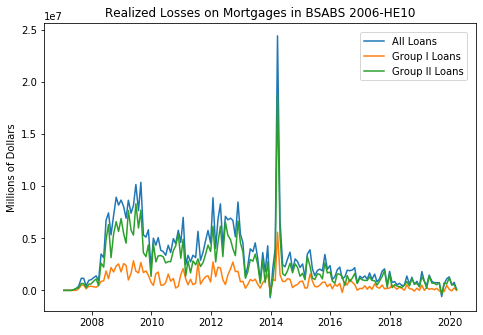

In [ ]:
graph = plt.figure()
axes = graph.add_axes([0,0,1,1])
axes.plot(read_RL_test.xs('Total', level=1),label='All Loans')
axes.plot(read_RL_test.xs('Group I', level=1),label='Group I Loans')
axes.plot(read_RL_test.xs('Group II', level=1),label='Group II Loans')
axes.set_title('Realized Losses on Mortgages in BSABS 2006-HE10')
axes.set_ylabel('Millions of Dollars')
axes.legend(loc=[0.73,0.8])
plt.show()